In [16]:
import Pkg; Pkg.activate(@__DIR__); Pkg.instantiate()

  Activating environment at `~/GitHub/lecture-notebooks/Lecture 11/Project.toml`


In [17]:
using LinearAlgebra
using StaticArrays
using RobotDynamics
import RobotZoo.Cartpole
using TrajectoryOptimization
using Altro

In [18]:
model = Cartpole()
n,m = size(model);

In [19]:
N = 101
Tf = 5.0
h = Tf/(N-1)

0.05

In [20]:
x0 = @SVector zeros(n)
xf = @SVector [0, pi, 0, 0];  # i.e. swing up

In [21]:
# Set up
Q = 1.0*Diagonal(@SVector ones(n))
Qf = 100.0*Diagonal(@SVector ones(n))
R = 0.1*Diagonal(@SVector ones(m))
obj = LQRObjective(Q,R,Qf,xf,N);

In [25]:
# Create Empty ConstraintList
conSet = ConstraintList(n,m,N)

# Control Bounds
u_bnd = 3.0
bnd = BoundConstraint(n,m, u_min=-u_bnd, u_max=u_bnd)
add_constraint!(conSet, bnd, 1:N-1)

# Goal Constraint
goal = GoalConstraint(xf)
add_constraint!(conSet, goal, N)

In [26]:
prob = Problem(model, obj, xf, Tf, x0=x0, constraints=conSet);

In [27]:
u0 = @SVector fill(0.001,m)
U0 = [u0 for k = 1:N-1]
initial_controls!(prob, U0)
rollout!(prob);

In [28]:
opts = SolverOptions(
    cost_tolerance_intermediate=1e-3,
    penalty_scaling=10.,
    penalty_initial=1.0
)

altro = ALTROSolver(prob, opts)
set_options!(altro, show_summary=true)
solve!(altro);


SOLVE COMPLETED
 solved using the ALTRO Solver,
 part of the Altro.jl package developed by the REx Lab at Stanford and Carnegie Mellon Universities

  Solve Statistics
    Total Iterations: 97
    Solve Time: 19.242791999999998 (ms)

  Covergence
    Terminal Cost: 54.73317974139106
    Terminal dJ: 7.166105297784497e-5
    Terminal gradient: 0.0018706099261702532
    Terminal constraint violation: 5.530829798594539e-7
    Solve Status: SOLVE_SUCCEEDED


In [29]:
# Extract the solution
X = states(altro);
U = controls(altro);

In [30]:
using TrajOptPlots
using MeshCat
using Plots

vis = Visualizer()
render(vis)

┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://127.0.0.1:8715
└ @ MeshCat /Users/zac/.julia/packages/MeshCat/GlCMx/src/visualizer.jl:73


MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), Set{Any}(), ip"127.0.0.1", 8715))

In [31]:
TrajOptPlots.set_mesh!(vis, model)

MeshCat Visualizer with path /meshcat/robot/cart/pole at http://127.0.0.1:8715

In [32]:
visualize!(vis, altro);

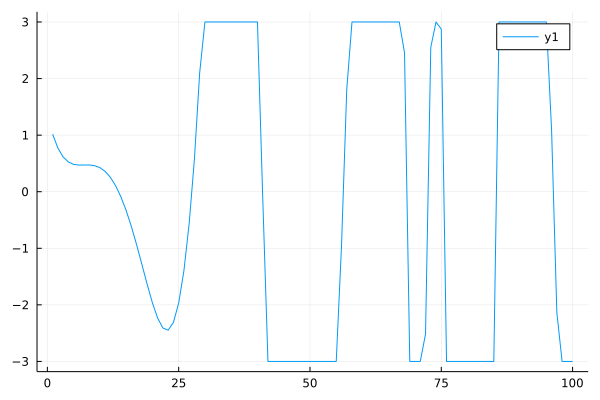

In [15]:
plot(U)